####**Contents:** Clustering with Hierarchical and using PCA with n = 2

1.1 Read file<br/>
1.2 Data preprocessing<br/>
1.3 Cosine similarity & distance<br/>
1.4 Hierarchical clustering<br/>
1.5 Set a threshold<br/>
1.6 Save the results<br/>

##**1. Text Clustering**

### import Library
----

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import complete, average, ward, dendrogram, fcluster
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter


###**1.1 Read file traindata.csv**


---


In [2]:
data = pd.read_csv('traindatanorm.csv')

# Number of observations and variables
print(data.shape)
# Overview dataset
data.describe()

(7809, 5)


Main_Category                   Course_Title  \
count           7809                           7809   
unique            10                           7180   
top        lifestyle  chatgpt gener ai help content   
freq             833                              5   

                                              Description     Course_Content  \
count                                                7809               7809   
unique                                               7146               7154   
top     comprehens practic question depth answer insig...  better navig code   
freq                                                    8                 10   

        Lecturers_name  
count             7809  
unique            4076  
top     alex genadinik  
freq                48

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\3621229007.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Main_Category', data=data, palette='pastel')
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\3621229007.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


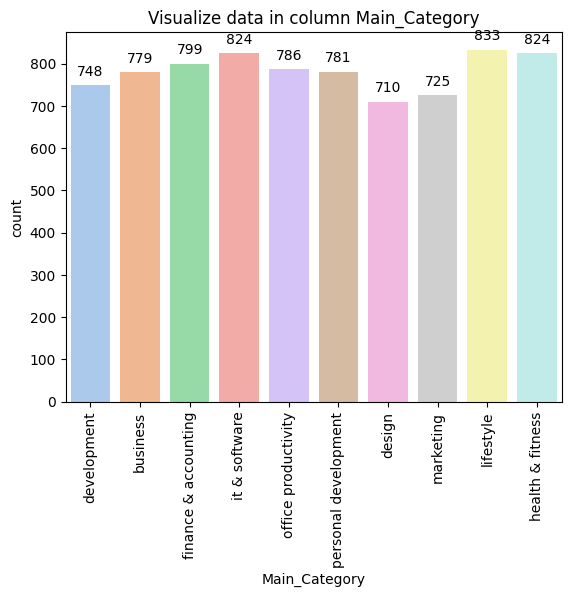

Tổng số khoá học: 7809


In [3]:
ax = sns.countplot(x='Main_Category', data=data, palette='pastel')
plt.title('Visualize data in column Main_Category')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.show()
total_courses = len(data)  # hoặc data.shape[0]
print("Tổng số khoá học:", total_courses)

###**1.2 Data preprocessing**


---

####***1.2.1 Concatenate cells(features) into a string with separator (ignore NA)***


In [4]:
df = pd.DataFrame(data.Main_Category)
df['content'] = data.iloc[:,1:].apply(lambda x: ','.join(x.dropna().values.tolist()), axis=1)
labels = np.array(df['Main_Category'])
df

Main_Category                                            content
0          development  complet javascript 2024 zero expert,modern jav...
1          development  javascript weird part,advanc javascript everyo...
2          development  javascript basic beginn,javascript master fund...
3          development  modern javascript begin 2.0 2024,36 hour maste...
4          development  javascript beginn practic exercis,javascript b...
...                ...                                                ...
7804  health & fitness  kundalini awaken activ shakti power,awaken sle...
7805  health & fitness  ancient calisthen basic kundalini kriya yoga,a...
7806  health & fitness  kundalini awaken,unleash power energi insid tr...
7807  health & fitness  energi heal kundalini yoga eft,chang life attr...
7808  health & fitness  awaken kundalini energi open seven chakra,kund...

[7809 rows x 2 columns]

In [5]:
# Tạo một từ điển để lưu trữ tần suất từ cho mỗi nhãn chính
main_category_word_freq = {}

# Duyệt qua từng nhãn chính
for category in df['Main_Category'].unique():
    # Lấy tất cả các văn bản trong nhãn chính này
    texts = df[df['Main_Category'] == category]['content'].values
    combined_text = ' '.join(texts)
    
    # Đếm tần suất các từ
    word_counter = Counter(combined_text.split())
    
    # Lưu kết quả vào từ điển
    main_category_word_freq[category] = word_counter

# Hiển thị 10 từ xuất hiện nhiều nhất cho mỗi nhãn chính
for category, counter in main_category_word_freq.items():
    print(f"\nTop 10 words in '{category}':")
    for word, count in counter.most_common(10):
        print(f"{word}: {count}")



Top 10 words in 'development':
app: 391
build: 357
game: 356
program: 336
data: 316
c: 301
react: 205
applic: 203
complet: 183
languag: 169

Top 10 words in 'business':
busi: 660
manag: 390
write: 298
sale: 280
ai: 221
gener: 193
chatgpt: 177
market: 175
custom: 167
email: 159

Top 10 words in 'finance & accounting':
trade: 371
financi: 350
account: 242
busi: 231
manag: 216
risk: 212
financ: 173
intern: 154
invest: 136
bank: 133

Top 10 words in 'it & software':
aw: 323
network: 314
secur: 298
exam: 256
program: 205
linux: 198
practic: 189
system: 178
c: 175
azur: 175

Top 10 words in 'office productivity':
sap: 557
data: 556
excel: 506
googl: 415
oracl: 362
sql: 237
manag: 235
app: 214
microsoft: 211
databas: 204

Top 10 words in 'personal development':
manag: 278
life: 192
commun: 181
relationship: 173
coach: 168
work: 158
effect: 146
person: 143
busi: 143
emot: 133

Top 10 words in 'design':
design: 789
game: 259
adob: 241
web: 197
ux: 182
effect: 172
websit: 163
ui: 156
app: 150
c

####***1.2.2 Tf-idf vectorizer***


In [6]:
# text contents in dataframe to array
contents = np.array(df['content']) 
contents

# tfidf vectorizer
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b') 
tfidf_matrix = vectorizer.fit_transform(contents)
tfidf_matrix

# See the first vector (optional)
first_vector = tfidf_matrix[0]
first_dict = pd.DataFrame(first_vector.T.todense(), index = vectorizer.get_feature_names_out(), columns = ["tfidf"])

# See all terms
terms = vectorizer.get_feature_names_out()
print("Terms: ",terms)

# Store vectorized texts in df
df['tfidf'] = list(tfidf_matrix.toarray())
df

Terms:  ['0' '00' '000' ... 'zumba' 'zybo' 'zynq']


Main_Category                                            content  \
0          development  complet javascript 2024 zero expert,modern jav...   
1          development  javascript weird part,advanc javascript everyo...   
2          development  javascript basic beginn,javascript master fund...   
3          development  modern javascript begin 2.0 2024,36 hour maste...   
4          development  javascript beginn practic exercis,javascript b...   
...                ...                                                ...   
7804  health & fitness  kundalini awaken activ shakti power,awaken sle...   
7805  health & fitness  ancient calisthen basic kundalini kriya yoga,a...   
7806  health & fitness  kundalini awaken,unleash power energi insid tr...   
7807  health & fitness  energi heal kundalini yoga eft,chang life attr...   
7808  health & fitness  awaken kundalini energi open seven chakra,kund...   

                                                  tfidf  
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3     [0.16597363238942162, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...                                                 ...  
7804  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
7805  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
7806  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
7807  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
7808  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[7809 rows x 3 columns]

####***1.2.3 Dimensionality reduction by PCA***

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(tfidf_matrix.toarray())

from sklearn.decomposition import PCA
pca = PCA().fit(data_rescaled)

In [8]:
pca = PCA(n_components=2) 
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())

###**1.3 Cosine similarity & distance**


---

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
# dist = 1 - cosine_similarity(tfidf_matrix)
dist = 1 - cosine_similarity(tfidf_pca)
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

###**1.4 Hierarchical clustering**


---


In [10]:
from scipy.cluster.hierarchy import fcluster, complete, average, ward, dendrogram

####***1.4.1 Complete-Link***


In [11]:
linkage_matrix_complete = complete(dist)

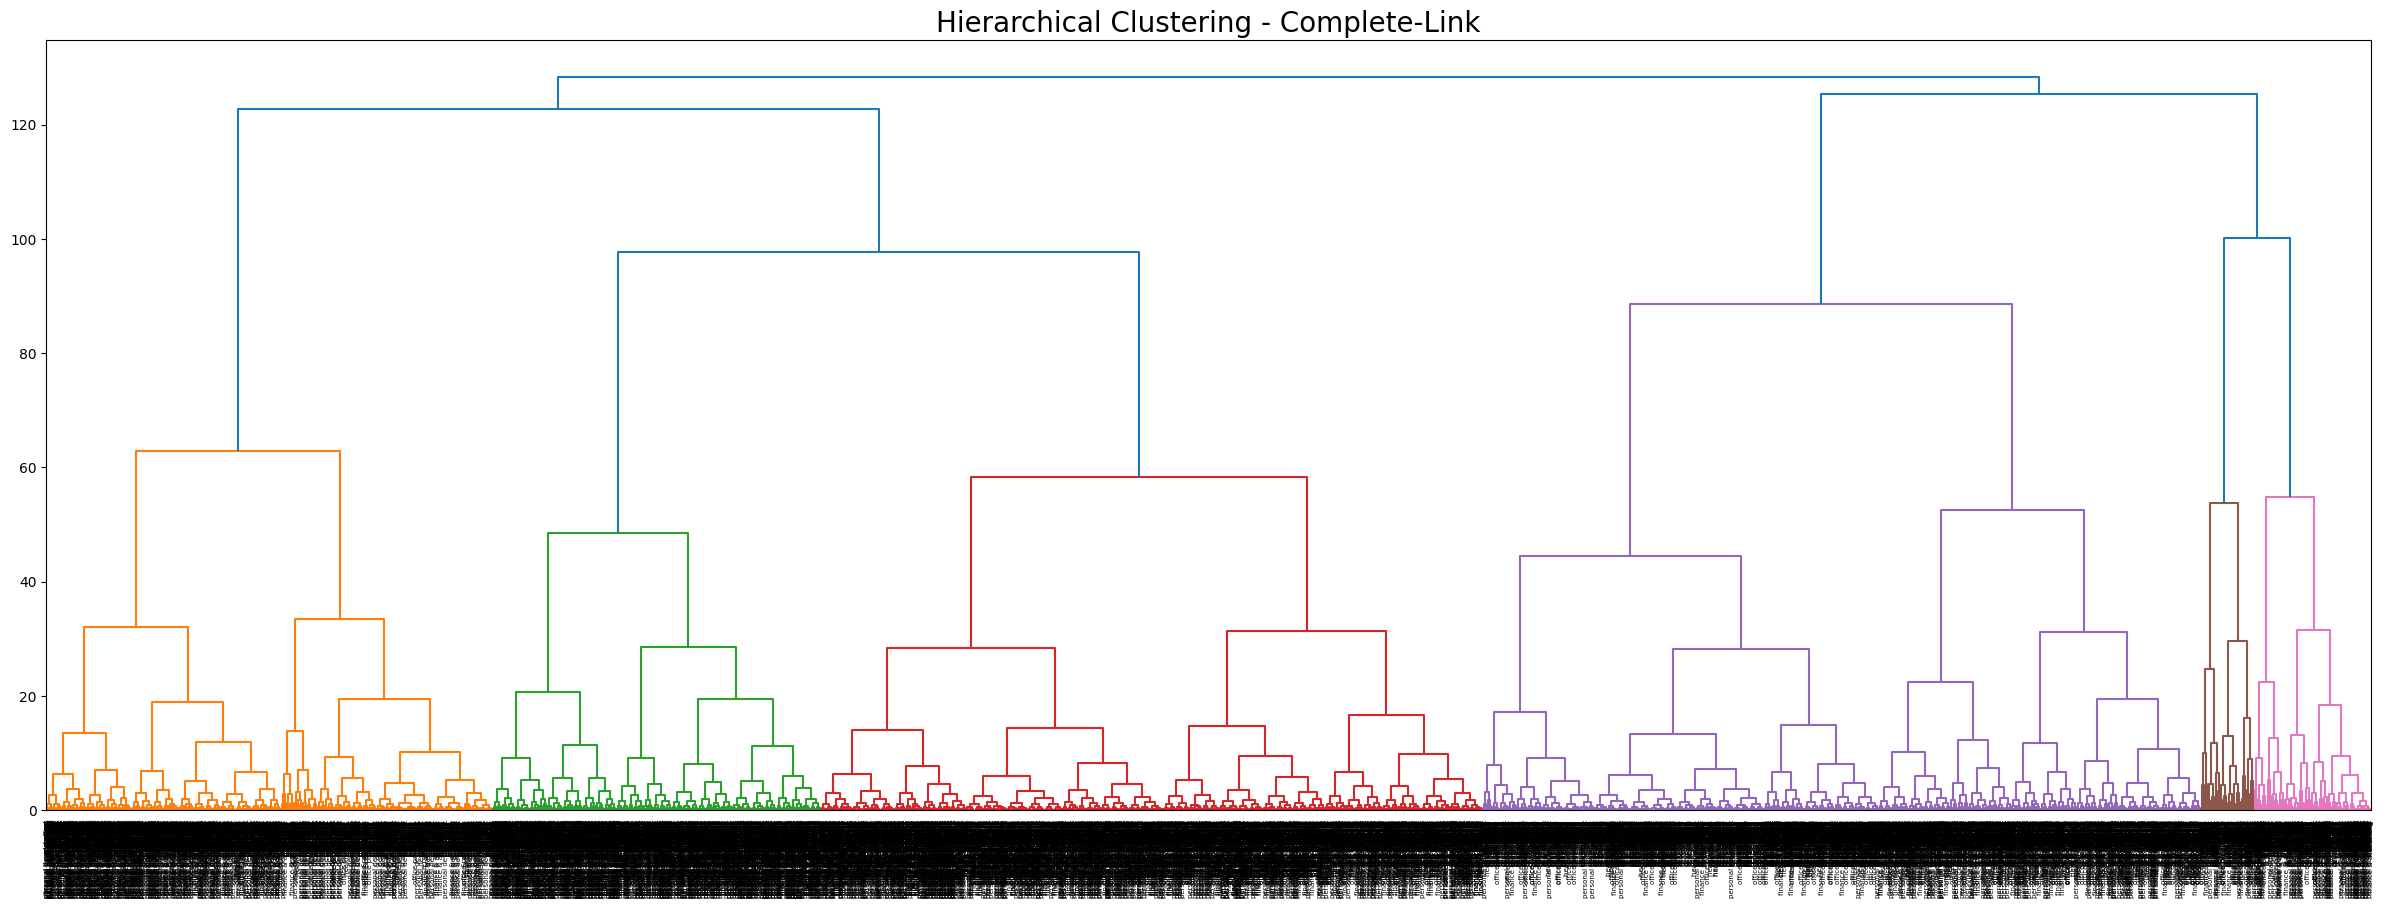

In [12]:

# plot
plt.subplots(figsize=(30, 10)) # set size
plt.title('Hierarchical Clustering - Complete-Link', fontsize=20)
dn_complete = dendrogram(linkage_matrix_complete, labels=labels);

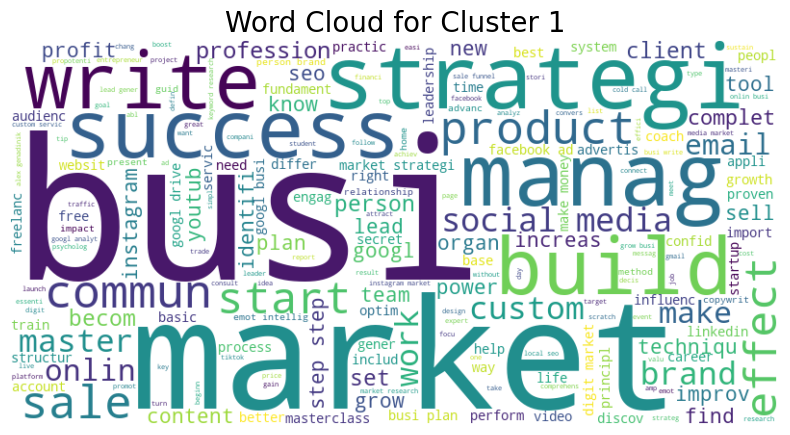

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\4269490442.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


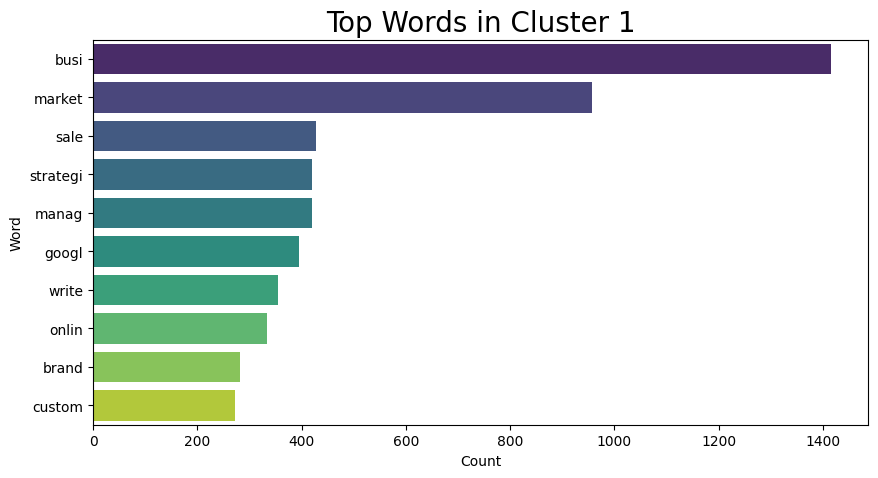

Cluster 1 has 49156 words.

Top 10 words in Cluster 1:
busi: 1416
market: 957
sale: 428
strategi: 420
manag: 420
googl: 395
write: 354
onlin: 334
brand: 281
custom: 272


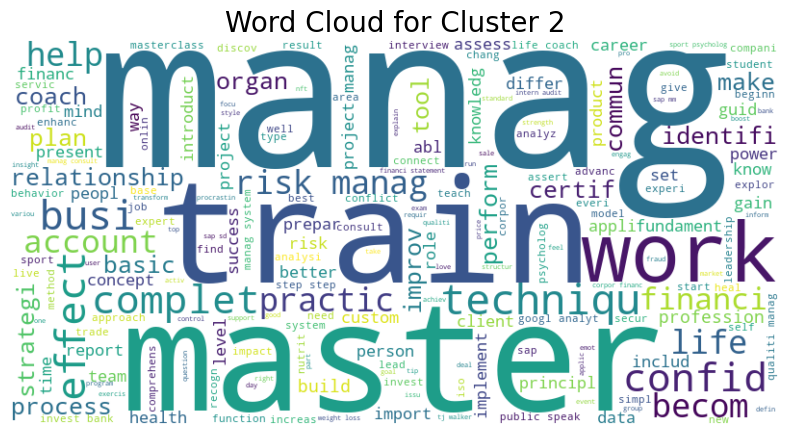

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\4269490442.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


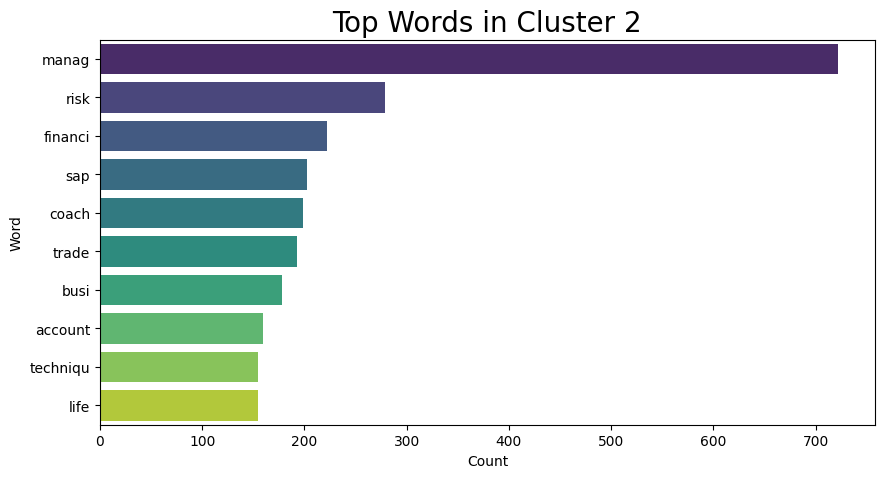

Cluster 2 has 35887 words.

Top 10 words in Cluster 2:
manag: 722
risk: 279
financi: 222
sap: 203
coach: 199
trade: 193
busi: 178
account: 160
techniqu: 155
life: 155


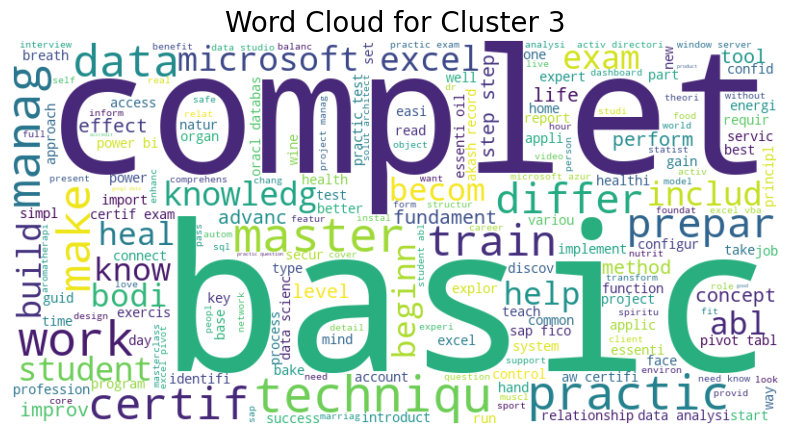

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\4269490442.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


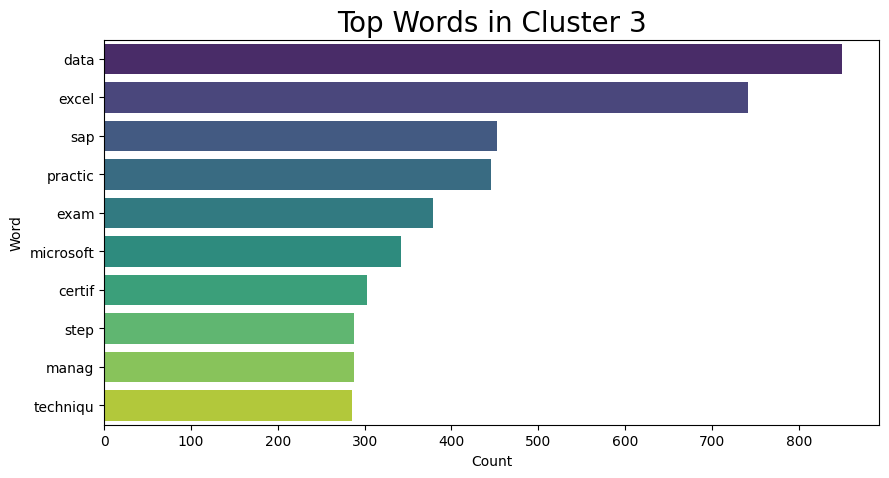

Cluster 3 has 70018 words.

Top 10 words in Cluster 3:
data: 850
excel: 741
sap: 452
practic: 445
exam: 379
microsoft: 342
certif: 303
step: 288
manag: 288
techniqu: 285


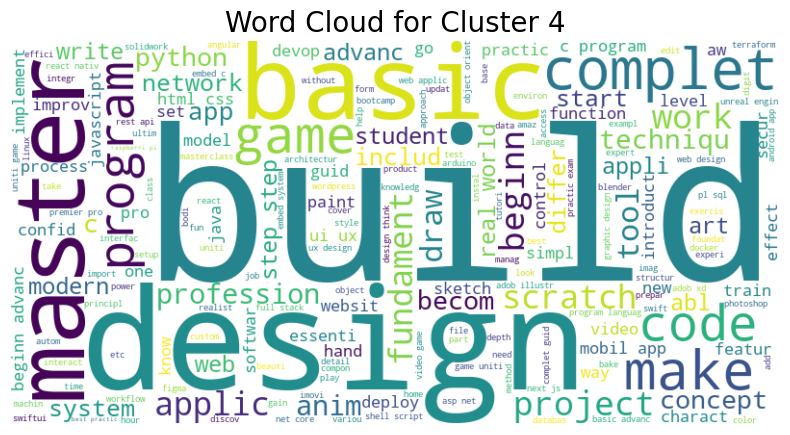

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\4269490442.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


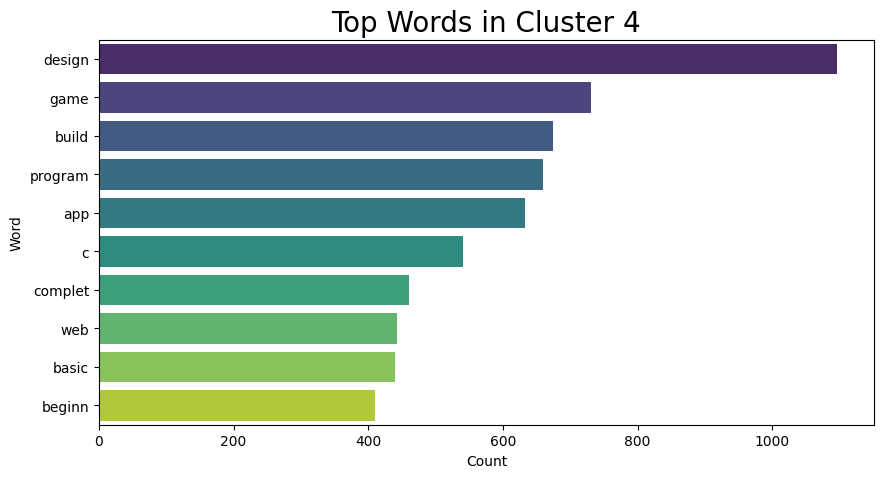

Cluster 4 has 74300 words.

Top 10 words in Cluster 4:
design: 1096
game: 730
build: 674
program: 660
app: 632
c: 541
complet: 461
web: 442
basic: 439
beginn: 410


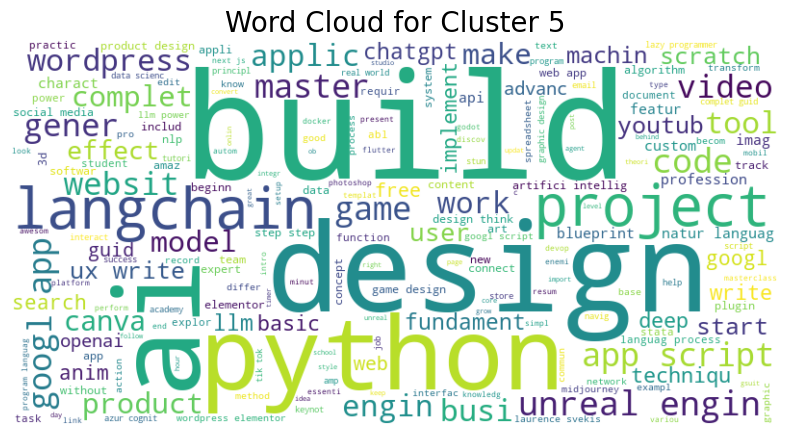

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\4269490442.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


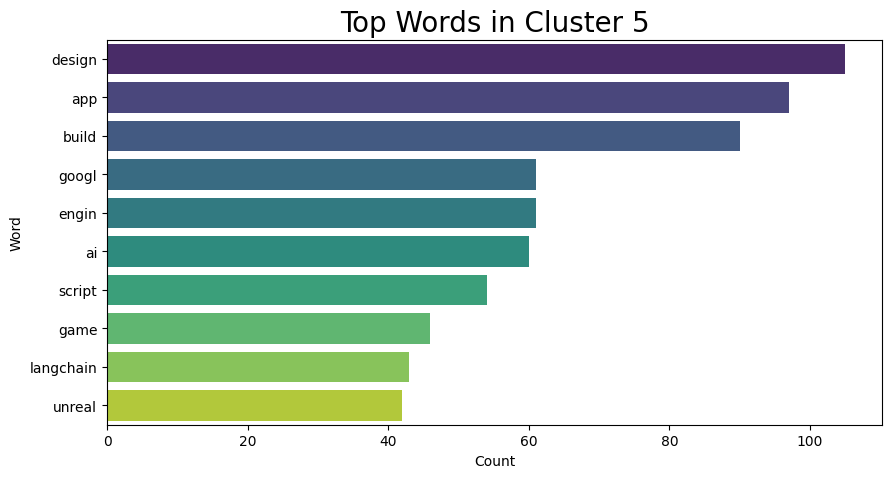

Cluster 5 has 5900 words.

Top 10 words in Cluster 5:
design: 105
app: 97
build: 90
googl: 61
engin: 61
ai: 60
script: 54
game: 46
langchain: 43
unreal: 42


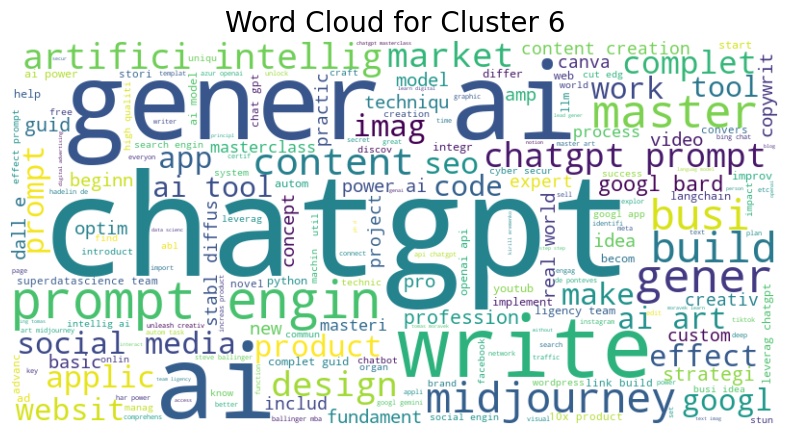

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\4269490442.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


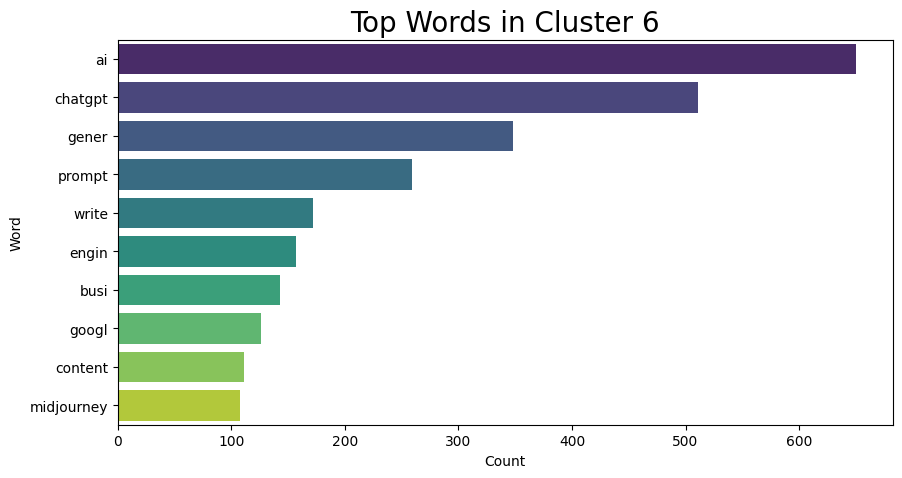

Cluster 6 has 14939 words.

Top 10 words in Cluster 6:
ai: 650
chatgpt: 511
gener: 348
prompt: 259
write: 172
engin: 157
busi: 143
googl: 126
content: 111
midjourney: 108


In [13]:
# 6. Set a threshold and assign clusters
threshold = 0.7 * np.max(linkage_matrix_complete[:, 2])
clusters = fcluster(linkage_matrix_complete, threshold, criterion='distance')
df['cluster'] = clusters

# Sắp xếp lại DataFrame theo cột "cluster"
df_sorted = df.sort_values(by='cluster')

# 7. Generate word clouds for each cluster
unique_clusters = df_sorted['cluster'].unique()

# 7. Generate word clouds and bar plots for each cluster
for cluster in unique_clusters:
    cluster_texts = df_sorted[df_sorted['cluster'] == cluster]['content'].values
    combined_text = ' '.join(cluster_texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}', fontsize=20)
    plt.show()

    # Bar plot for top words
    word_counter = Counter(combined_text.split())
    most_common_words = word_counter.most_common(10)  # Top 10 words
    words = [word for word, count in most_common_words]
    counts = [count for word, count in most_common_words]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts, y=words, palette='viridis')
    plt.title(f'Top Words in Cluster {cluster}', fontsize=20)
    plt.xlabel('Count')
    plt.ylabel('Word')
    plt.show()

    # Count the total number of words and print
    total_words = sum(word_counter.values())
    print(f"Cluster {cluster} has {total_words} words.")

    # Print the count of the top 10 words
    print(f"\nTop 10 words in Cluster {cluster}:")
    for word, count in most_common_words:
        print(f"{word}: {count}")



####***1.4.2 Group Average***


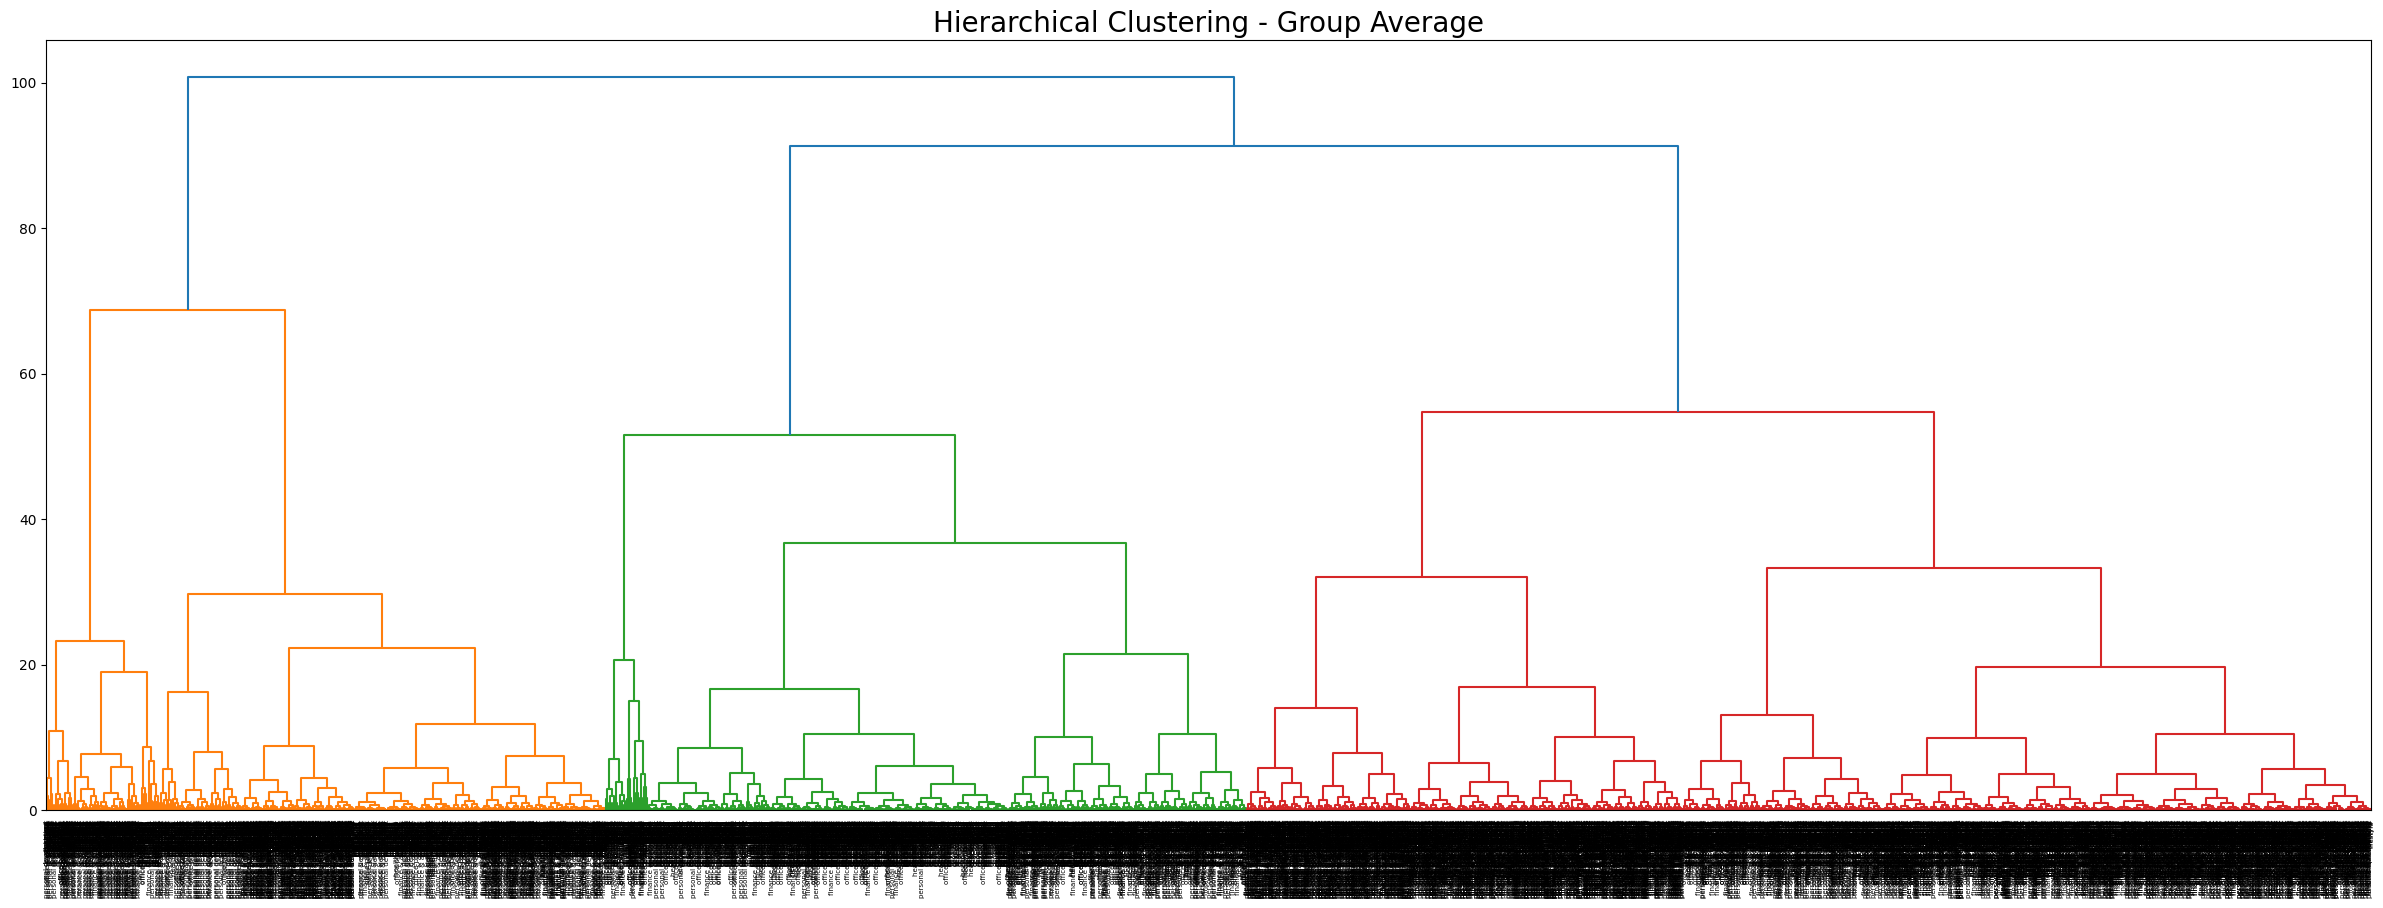

In [14]:
linkage_matrix_avg = average(dist)

# plot
plt.subplots(figsize=(30, 10)) # set size
plt.title('Hierarchical Clustering - Group Average', fontsize=20)
dn_avg = dendrogram(linkage_matrix_avg, labels=labels);

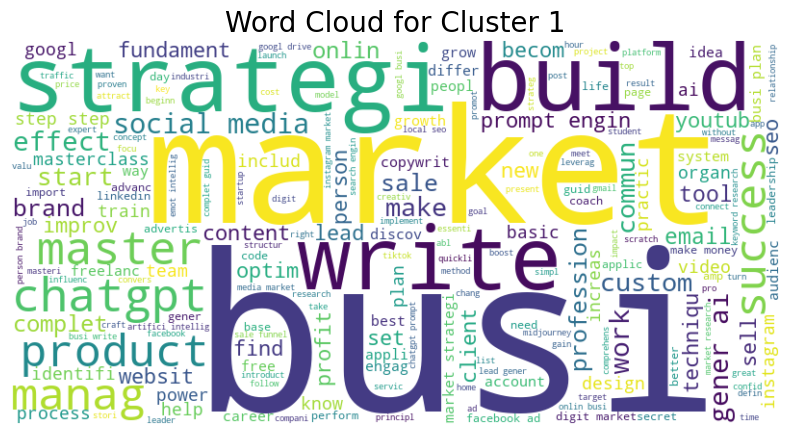

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\446343390.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


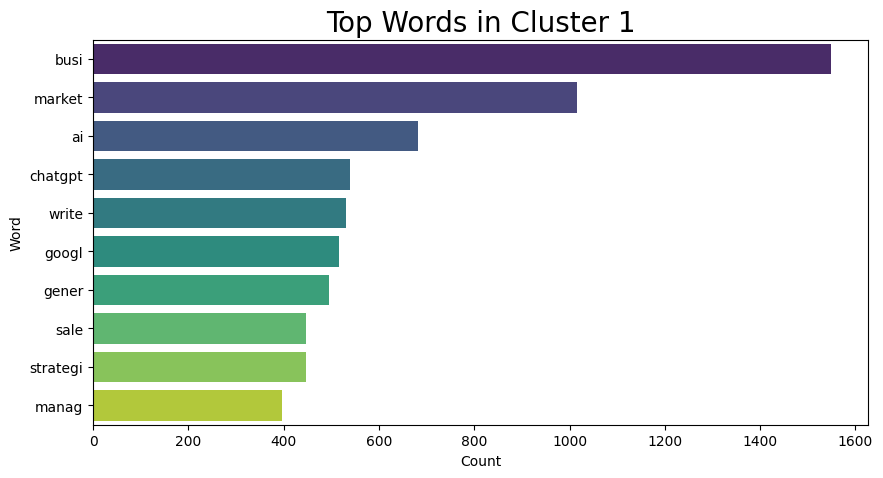

Cluster 1 has 63755 words.

Top 10 words in Cluster 1:
busi: 1549
market: 1016
ai: 681
chatgpt: 539
write: 530
googl: 517
gener: 496
sale: 448
strategi: 447
manag: 396


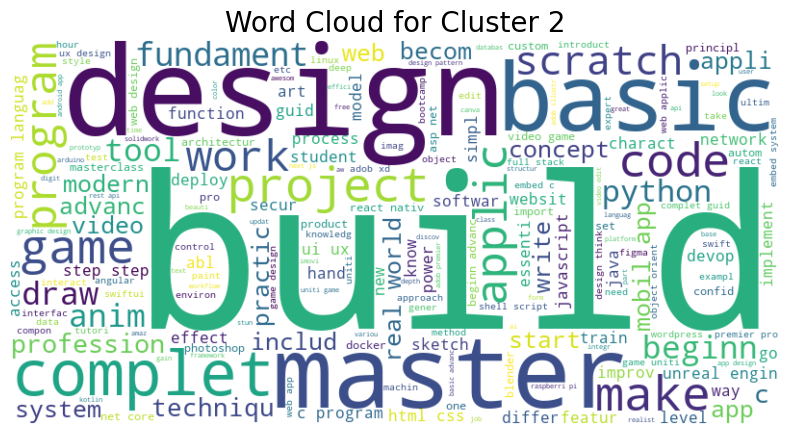

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\446343390.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


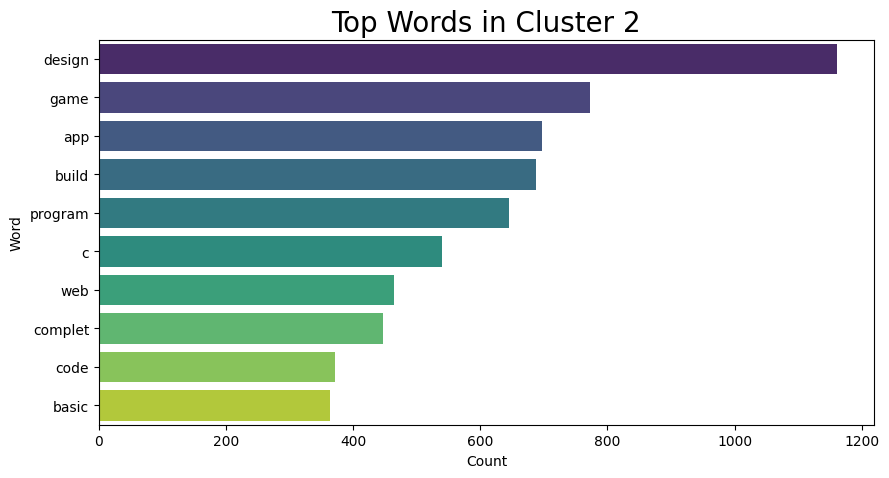

Cluster 2 has 67053 words.

Top 10 words in Cluster 2:
design: 1161
game: 773
app: 697
build: 687
program: 645
c: 539
web: 464
complet: 447
code: 372
basic: 363


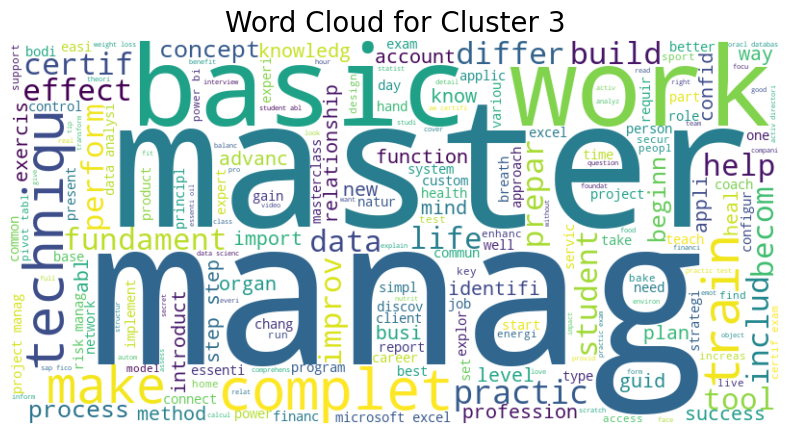

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\446343390.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


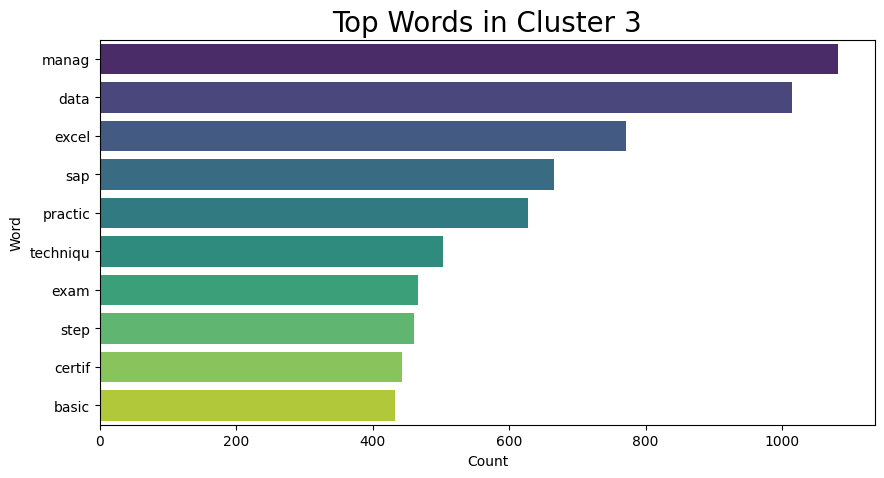

Cluster 3 has 119392 words.

Top 10 words in Cluster 3:
manag: 1082
data: 1015
excel: 771
sap: 666
practic: 627
techniqu: 503
exam: 466
step: 461
certif: 443
basic: 432


In [15]:

# 6. Set a threshold and assign clusters
threshold = 0.7 * np.max(linkage_matrix_avg [:, 2])
clusters = fcluster(linkage_matrix_avg , threshold, criterion='distance')
df['cluster'] = clusters

# Sắp xếp lại DataFrame theo cột "cluster"
df_sorted = df.sort_values(by='cluster')

# 7. Generate word clouds and bar plots for each cluster
unique_clusters = df_sorted['cluster'].unique()

cluster_labels = {}
for cluster in unique_clusters:
    cluster_texts = df_sorted[df_sorted['cluster'] == cluster]['content'].values
    combined_text = ' '.join(cluster_texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}', fontsize=20)
    plt.show()

    # Bar plot for top words
    word_counter = Counter(combined_text.split())
    most_common_words = word_counter.most_common(10)  # Top 10 words
    words = [word for word, count in most_common_words]
    counts = [count for word, count in most_common_words]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts, y=words, palette='viridis')
    plt.title(f'Top Words in Cluster {cluster}', fontsize=20)
    plt.xlabel('Count')
    plt.ylabel('Word')
    plt.show()

    # Count the total number of words and print
    total_words = sum(word_counter.values())
    print(f"Cluster {cluster} has {total_words} words.")

    # Print the count of the top 10 words
    print(f"\nTop 10 words in Cluster {cluster}:")
    for word, count in most_common_words:
        print(f"{word}: {count}")

####***1.4.3 Ward***

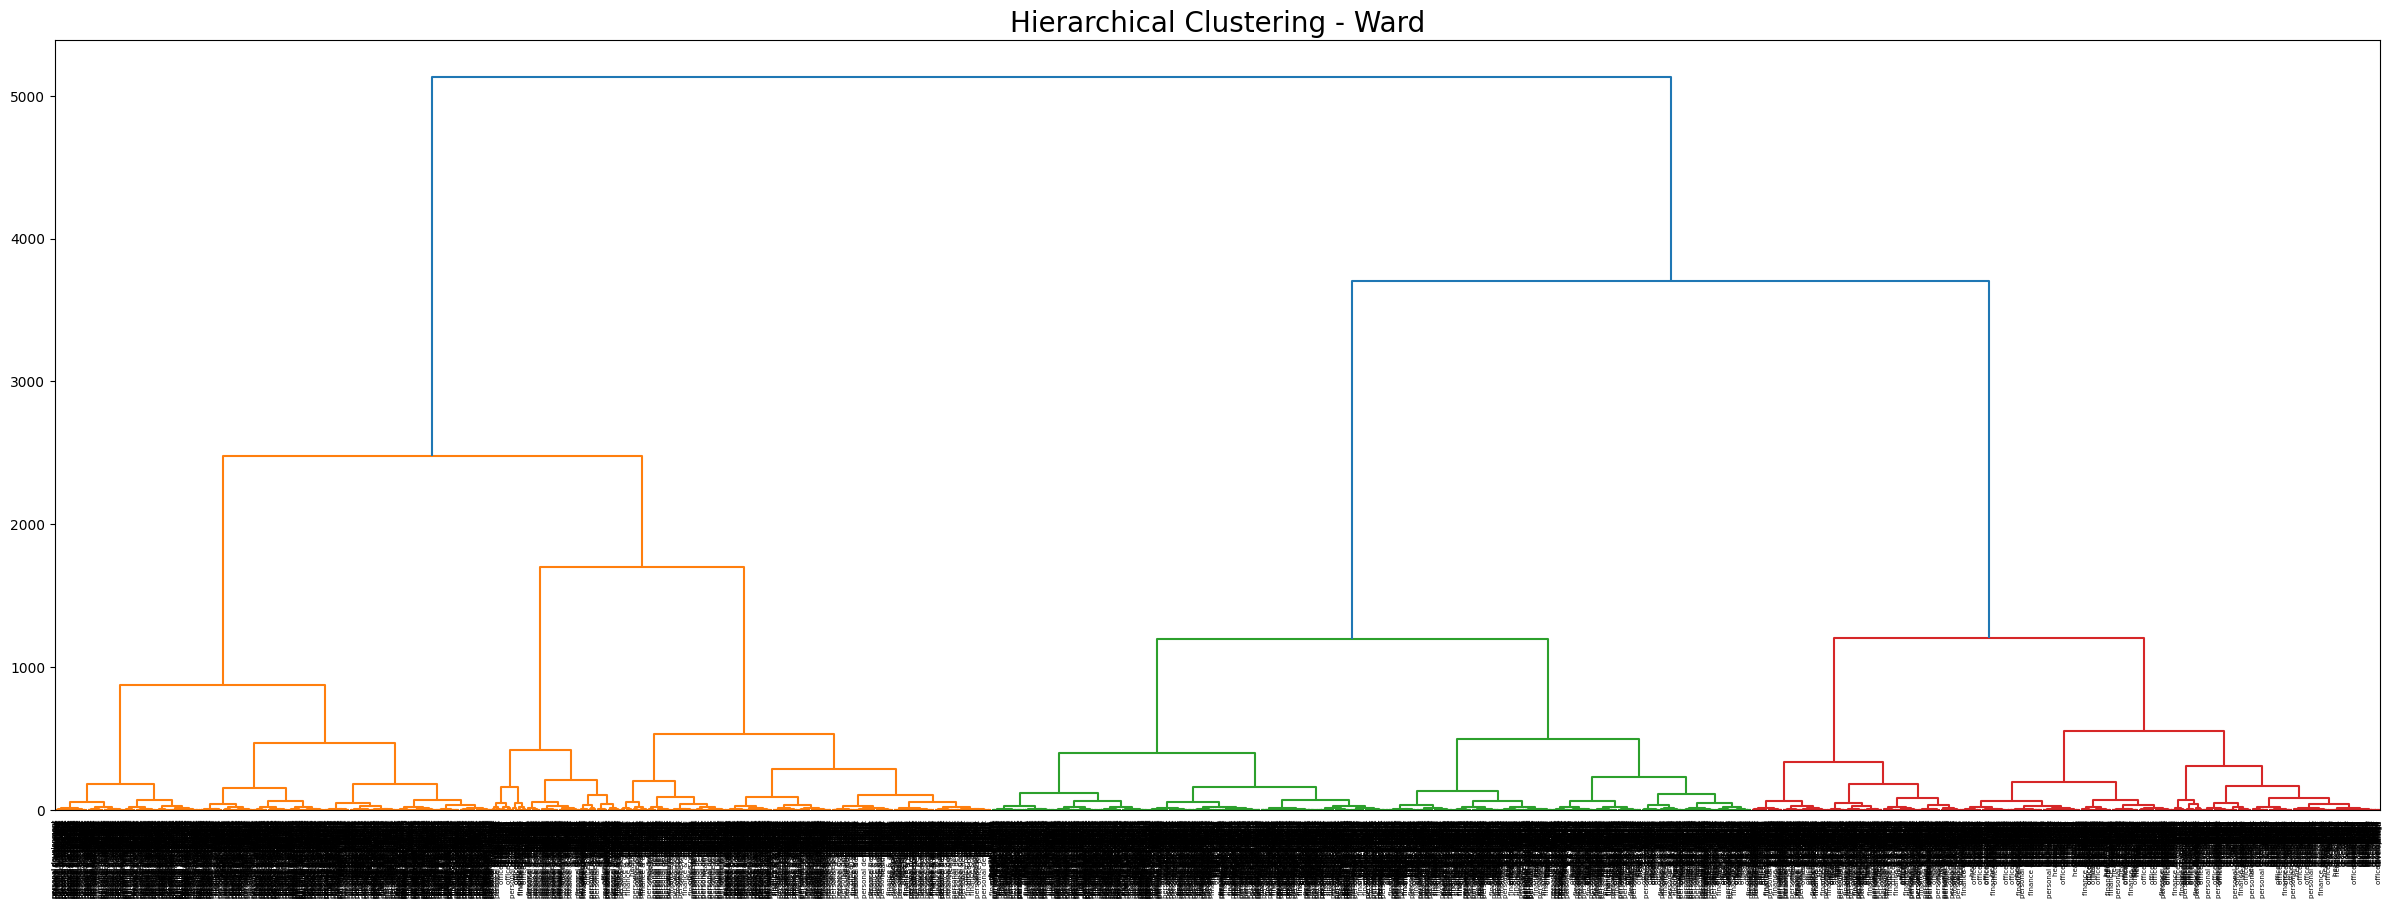

In [16]:
linkage_matrix_ward = ward(dist) 

# plot
plt.subplots(figsize=(30, 10)) # set size
plt.title('Hierarchical Clustering - Ward', fontsize=20)
dn_ward = dendrogram(linkage_matrix_ward, labels=labels);

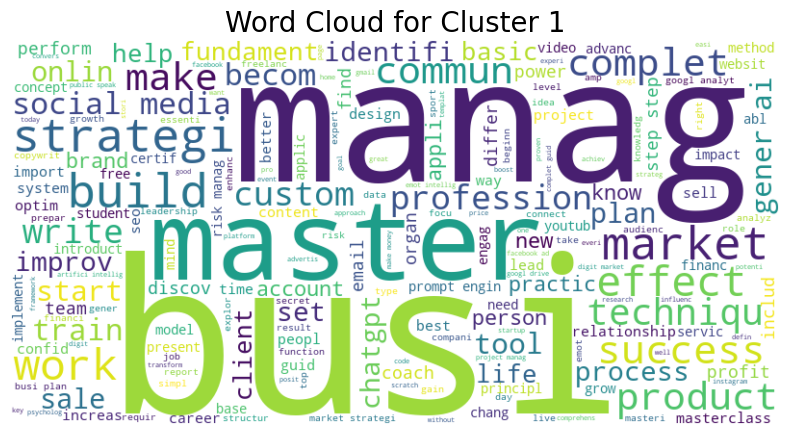

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\4038186563.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


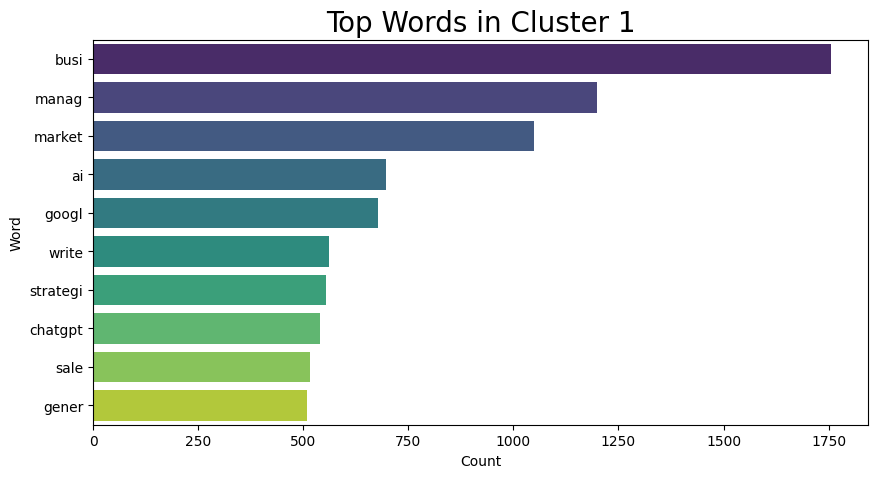

Cluster 1 has 105094 words.

Top 10 words in Cluster 1:
busi: 1756
manag: 1199
market: 1049
ai: 698
googl: 679
write: 562
strategi: 555
chatgpt: 541
sale: 517
gener: 509


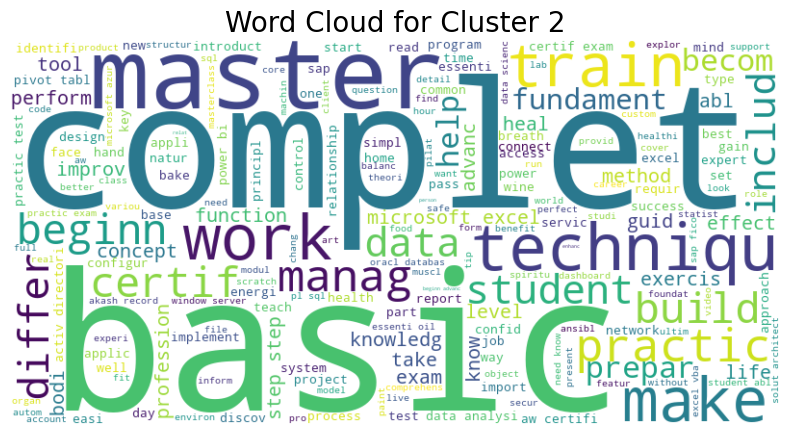

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\4038186563.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


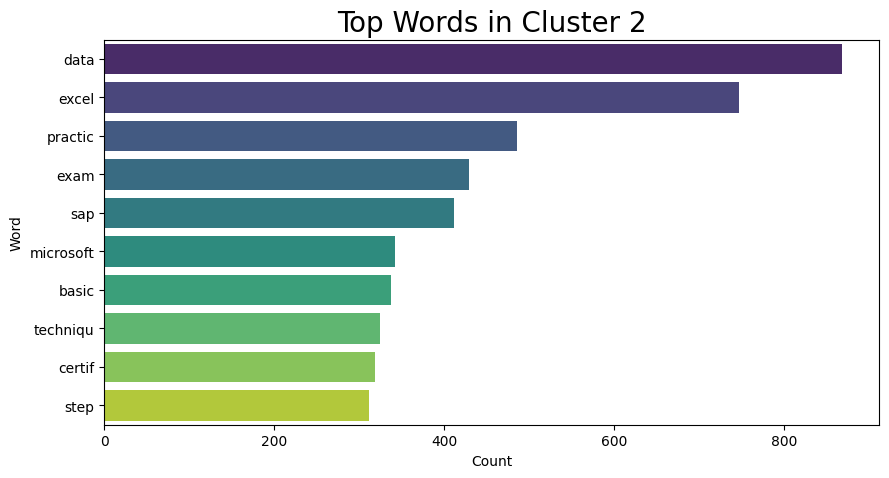

Cluster 2 has 79375 words.

Top 10 words in Cluster 2:
data: 868
excel: 747
practic: 485
exam: 429
sap: 412
microsoft: 342
basic: 337
techniqu: 324
certif: 318
step: 312


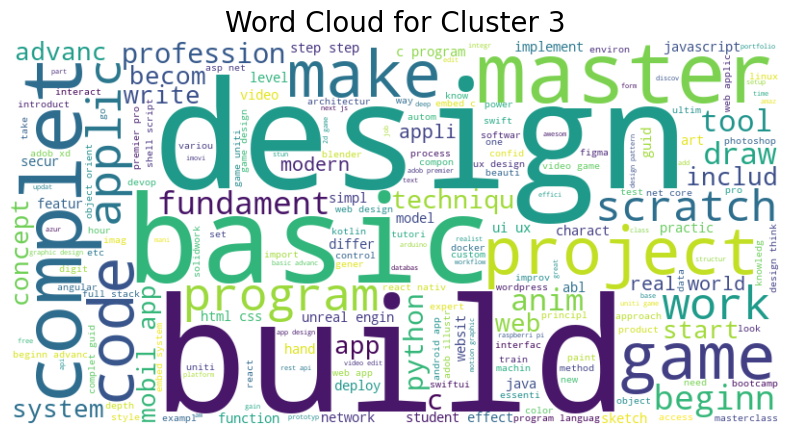

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_5272\4038186563.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


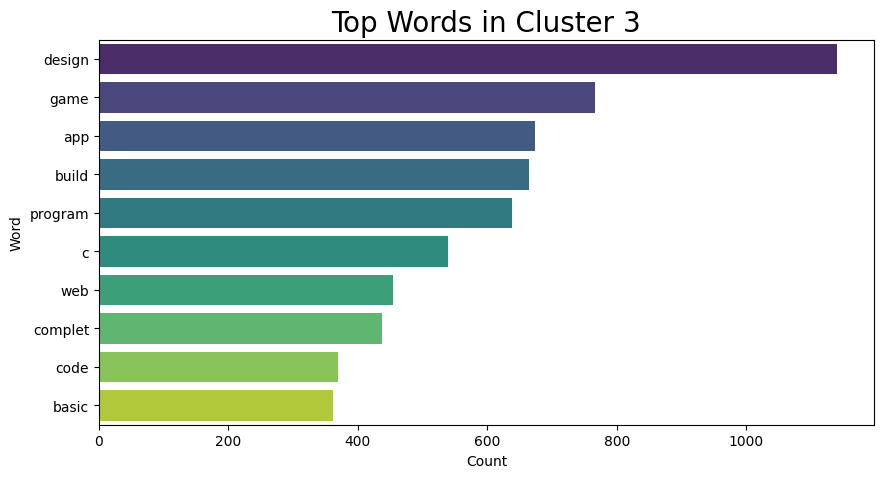

Cluster 3 has 65731 words.

Top 10 words in Cluster 3:
design: 1140
game: 767
app: 674
build: 665
program: 638
c: 539
web: 455
complet: 438
code: 369
basic: 361


In [17]:

# 6. Set a threshold and assign clusters
threshold = 0.7 * np.max(linkage_matrix_ward [:, 2])
clusters = fcluster(linkage_matrix_ward , threshold, criterion='distance')
df['cluster'] = clusters

# Sắp xếp lại DataFrame theo cột "cluster"
df_sorted = df.sort_values(by='cluster')

# 7. Generate word clouds and bar plots for each cluster
unique_clusters = df_sorted['cluster'].unique()

cluster_labels = {}
for cluster in unique_clusters:
    cluster_texts = df_sorted[df_sorted['cluster'] == cluster]['content'].values
    combined_text = ' '.join(cluster_texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}', fontsize=20)
    plt.show()

    # Bar plot for top words
    word_counter = Counter(combined_text.split())
    most_common_words = word_counter.most_common(10)  # Top 10 words
    words = [word for word, count in most_common_words]
    counts = [count for word, count in most_common_words]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts, y=words, palette='viridis')
    plt.title(f'Top Words in Cluster {cluster}', fontsize=20)
    plt.xlabel('Count')
    plt.ylabel('Word')
    plt.show()

    # Count the total number of words and print
    total_words = sum(word_counter.values())
    print(f"Cluster {cluster} has {total_words} words.")

    # Print the count of the top 10 words
    print(f"\nTop 10 words in Cluster {cluster}:")
    for word, count in most_common_words:
        print(f"{word}: {count}")
    

In [18]:
from sklearn.metrics import silhouette_score

# Set a threshold and assign clusters
threshold = 0.7 * np.max(linkage_matrix_complete[:, 2])
clusters_complete = fcluster(linkage_matrix_complete, threshold, criterion='distance')

# Compute Silhouette Score
silhouette_complete = silhouette_score(tfidf_matrix, clusters_complete)
print(f'Silhouette Score (Complete-Link): {silhouette_complete}')


Silhouette Score (Complete-Link): 0.003655302498153926


In [19]:
# Set a threshold and assign clusters
threshold = 0.7 * np.max(linkage_matrix_avg[:, 2])
clusters_avg = fcluster(linkage_matrix_avg, threshold, criterion='distance')

# Compute Silhouette Score
silhouette_avg = silhouette_score(tfidf_matrix, clusters_avg)
print(f'Silhouette Score (Group Average): {silhouette_avg}')


Silhouette Score (Group Average): 0.005032469363094998


In [20]:
# Set a threshold and assign clusters
threshold = 0.7 * np.max(linkage_matrix_ward[:, 2])
clusters_ward = fcluster(linkage_matrix_ward, threshold, criterion='distance')

# Compute Silhouette Score
silhouette_ward = silhouette_score(tfidf_matrix, clusters_ward)
print(f'Silhouette Score (Ward): {silhouette_ward}')


Silhouette Score (Ward): 0.004839820594813995
